In [14]:
%matplotlib inline

import os, pickle
from traitlets import Unicode, Bool, validate, TraitError, Int
from ipywidgets import DOMWidget, register

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

@register
class GameView(DOMWidget):
    _view_name = Unicode('GameView').tag(sync=True)
    _view_module = Unicode('game_widget').tag(sync=True)
    _view_module_version = Unicode('0.1.0').tag(sync=True)
    
    # This is probably not how message passing between front- and back-end should happen:
    value = Unicode('', help='Value for message passing.').tag(sync=True)
    grid = Unicode('X' * (8*8)).tag(sync=True)    
    counter = Int(0).tag(sync=True)
    total_num_turns = Int(0).tag(sync=True)

def create_widget_for_game(game_states):
    game_view = GameView(grid=game_states[0], value='')
    game_view.total_num_turns = len(game_states)
    def do_change(arg):
        if arg['new'] == 'INC':
            game_view.counter = min(game_view.counter+1, len(game_states)-1)
        elif arg['new'] == 'DEC':
            game_view.counter = max(game_view.counter-1, 0)
        elif arg['new'] == 'RESET':
            game_view.counter = 0
        game_view.grid = game_states[game_view.counter]
        game_view.value = ''
    game_view.observe(do_change, names=['value'])
    do_change({'new': 'RESET'})
    return game_view

def read_game_dumps(game_history_dir):
    all_game_filenames = os.listdir(game_history_dir)
    all_game_filenames = [g for g in all_game_filenames if g.endswith('.pkl')]
    dump_index_to_filename = {}
    for filename in all_game_filenames:
        index = int(filename.split('_')[-1].split('.')[0])
        dump_index_to_filename[index] = os.path.join(game_history_dir, filename)
    all_indices = sorted(dump_index_to_filename.keys())
    
    all_game_history = []
    all_game_results = []

    for index in all_indices:
        with open(dump_index_to_filename[index], 'rb') as f:
            game_results, game_history = pickle.load(f)
        assert len(game_results) == len(game_history), 'Length mismatch for {}'.format(dump_index_to_filename[index])
        all_game_history += game_history
        all_game_results += game_results
    
    all_game_num_turns = [len(history) for history in all_game_history]
    num_pieces_left = [len(history[-1].replace(' ', '')) for history in all_game_history]
    return all_game_results, all_game_history, all_game_num_turns, num_pieces_left

In [2]:
%%javascript
require.undef('game_widget');

define('game_widget', ['@jupyter-widgets/base'], function(widgets) {
    var GameView = widgets.DOMWidgetView.extend({
        
        render: function() {
            
            this.forward_button = document.createElement('a');
            this.forward_button.style = 'text-decoration: none; display: inline-block; padding: 8px 16px; background-color: #f1f1f1;';
            var forward_text = document.createTextNode('>');
            this.forward_button.appendChild(forward_text);
            this.forward_button.href = '#';
            
            this.turn_display = document.createTextNode('0');
            this.turn_display.style = 'padding: 2px 2px; border: 1px solid black; background-color: #f1f1f1;';
            
            this.backward_button = document.createElement('a');
            this.backward_button.style = 'text-decoration: none; display: inline-block; padding: 8px 16px; background-color: #f1f1f1;';
            var backward_text = document.createTextNode('<');
            this.backward_button.appendChild(backward_text);
            this.backward_button.href = '#';
            
            this.table = document.createElement('table');
            this.table.id = 'gameBoard';
            this.table.style = 'table-layout: fixed; width:240px;';
            this.trs = [];
            this.text_elements = [];
            
            for(var i=0; i<8; i++)
            {
                var new_tr = document.createElement('tr');
                new_tr.style = 'height: 30px;';
                var new_text_elements = [];
                for(var j=0; j<8; j++)
                {
                    var new_td = document.createElement('td');
                    new_td.id = 'gameBoard';
                    new_td.style = 'border: 1px solid black; padding: 4px 4px; width: 30px; text-align: center;'
                    var new_text = document.createTextNode('?');
                    new_td.appendChild(new_text);
                    new_text_elements.push(new_text);
                    new_tr.appendChild(new_td);
                }
                this.text_elements.push(new_text_elements);
                this.table.appendChild(new_tr);
            }
            
            this.el.appendChild(this.backward_button);
            this.el.appendChild(this.turn_display);
            this.el.appendChild(this.forward_button);
            this.el.appendChild(this.table);
            
            this.model.on('change:value', this.value_changed, this);
            this.model.on('change:grid', this.grid_changed, this);
            this.model.on('change:counter', this.counter_changed, this);
            
            this.forward_button.onclick = this.forward_clicked.bind(this);
            this.backward_button.onclick = this.backward_clicked.bind(this);
            
            this.grid_changed();
            this.counter_changed();
            
        },
                
        counter_changed: function() {
            this.turn_display.data = (this.model.get('counter')+1) + '/' + this.model.get('total_num_turns');
            //this.touch();
            console.log('counter_change');
        },
        
        grid_changed: function() {
            var new_grid = this.model.get('grid');
            for(var i=0; i<8; i++)
            {
                for(var j=0; j<8; j++)
                {
                    this.text_elements[i][j].data = new_grid[8*i + j];
                }
            }
        },
        
        forward_clicked: function() {
            this.model.set('value', 'INC');
            this.model.save_changes();
            this.touch();
            console.log(Object.keys(this.model));
        },

        backward_clicked: function() {
            this.model.set('value', 'DEC');
            this.model.save_changes();
            this.touch();
            console.log(Object.keys(this.model));
        },
    });
    
    return {
        GameView: GameView
    }
});

<IPython.core.display.Javascript object>

In [17]:
game_history_dir = '/Users/rjt/git/xsandos/games_dump'
game_results, game_history, num_turns, num_pieces_left = read_game_dumps(game_history_dir)
results_series = pd.Series(game_results)

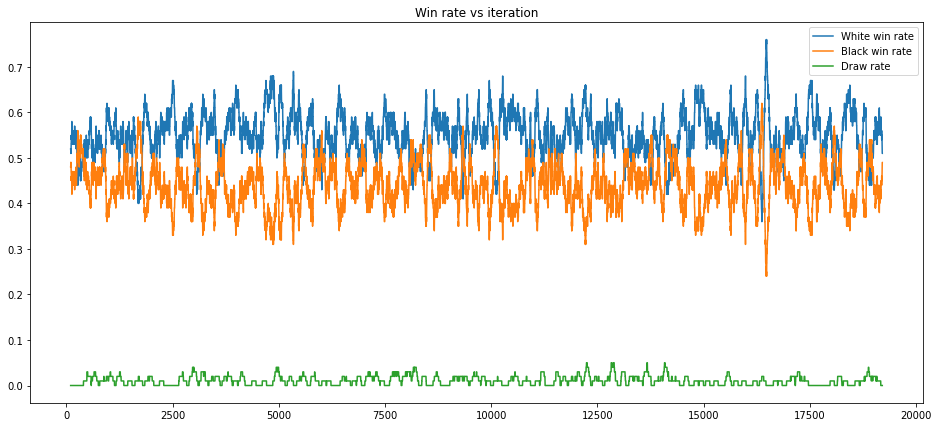

In [18]:
plt.figure(figsize=(16,7))
(results_series == 'WHITE').astype(int).rolling(100).mean().plot(label='White win rate')
(results_series == 'BLACK').astype(int).rolling(100).mean().plot(label='Black win rate')
(results_series == 'DRAW').astype(int).rolling(100).mean().plot(label='Draw rate')
plt.title('Win rate vs iteration')
l = plt.legend()

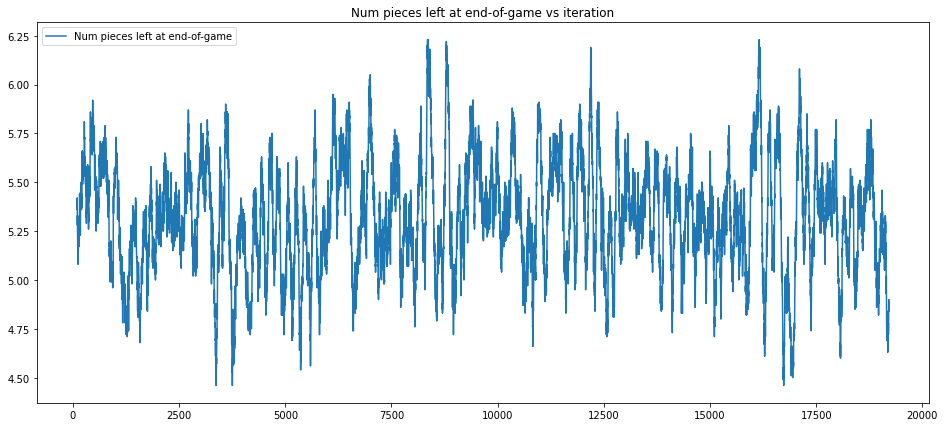

In [23]:
plt.figure(figsize=(16,7))
plt.title('Num pieces left at end-of-game vs iteration')
pd.Series(num_pieces_left).rolling(100).mean().plot(label='Num pieces left at end-of-game')
l = plt.legend()

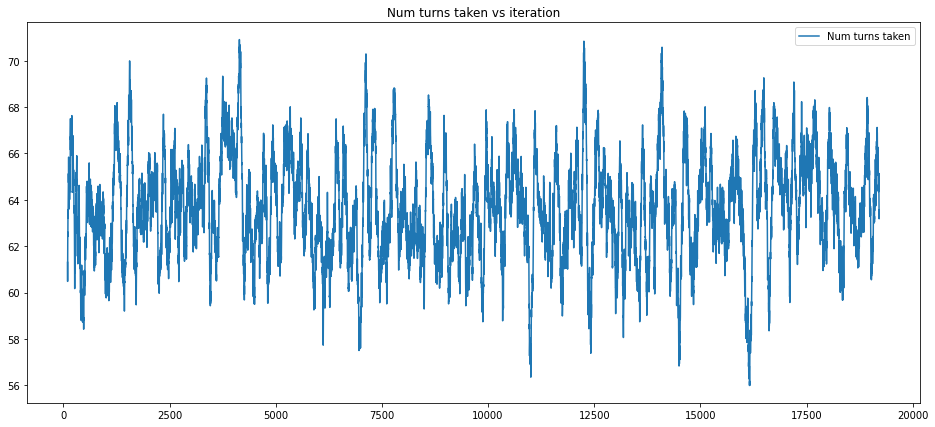

In [19]:
plt.figure(figsize=(16,7))
plt.title('Num turns taken vs iteration')
pd.Series(num_turns).rolling(100).mean().plot(label='Num turns taken')
l = plt.legend()

In [21]:
create_widget_for_game(game_history[-1])

GameView(grid=' W W W WW W W W  W W W W                B B B B  B B B BB B B B ', total_num_turns=90)